## Open this notebook from google drive
Go to "Edit" -> "Notebook settings" and enable GPU

In [1]:
!nvidia-smi

Tue Aug 25 13:47:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
pwd

'/content'

In [4]:
%cd gdrive/My\ Drive/spectrum_detector_v1
!ls

/content/gdrive/My Drive/spectrum_detector_v1
batch_detector.ipynb  detector_train.ipynb   mat	   saved_models2
batch_train.ipynb     DL_trainset	     mat2	   saved_models3
checkpoints	      EEG		     mat3	   train_subj.py
detector.ipynb	      generate_images_v2.py  __pycache__   utils.py
detector_subj.py      logs		     saved_models


# Start my python code here

In [5]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from numpy import save, load
from scipy.io import loadmat, savemat
from utils import normalize_matrix_1, plot1bar

In [6]:
# Re-load the model with the best validation accuracy
model_dir = os.path.join(os.getcwd(), 'saved_models3')
#model_name = 's21_best_trained_model_40epochs_devAVG5_100.h5'
#model_name = 's21_best_trained_model_40epochs_devAVG50_100.h5'
# model_name = 's21_best_trained_model_40epochs_devAVG100.h5'
model_name = 's21_best_trained_model.h5'

model= keras.models.load_model(os.path.join(model_dir, model_name))

labels_full   = [4, 6, 27, 33, 35, 37, 39, 43, 45, 66, 72, 76, 78, 99,105,111,117]
labels_subset = [6, 33, 37, 39, 43, 66, 72, 78, 99, 117] # (1)
labels_subset2= [6, 33, 37, 39, 43, 45, 66, 72, 76, 78, 99, 117] # (2) <<
labels_subset3= [6, 33, 35, 37, 39, 43, 45, 66, 72, 76, 78, 99, 117] # (3)

In [7]:
# choose one annotation from above <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
labels2use = labels_full
labels2plt = np.array(labels2use)-1 # python starts from 0


In [8]:
#%% load raw SNR data sets (.mat)
subj = 's23'

# (1) test set: AVG-EEG on day 2
AVG_spectrum_s1 = 'DL_trainset/AVG96/' + subj + '.mat'
file = loadmat(AVG_spectrum_s1)
data_test_AVG = file['SNR3D'] # (96, 60, 120)

# (2) test set: randomly-selected EEG on day 2
filename1 = 'DL_trainset/AVG_ram100/' + subj + '.mat'
file = loadmat(filename1)
data_test_ram = file['SNR3D_arr'] # (100, 60, 120) x 5

Test saved model

In [9]:
#%% test (1) the best_trained_model on test set: AVG-EEG on day 2
data1 =  data_test_AVG
data1 =  normalize_matrix_1(data1) # normalize to [0-1]
predictions = model.predict(data1)

#%% save Matrix from Python to MATLAB (.mat data) <<<<<<<<<<<<
pred_AVG = predictions
mdic = {"predictions_3D": pred_AVG}

save_dir = os.path.join(os.getcwd(), 'mat3')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
pred_savename = subj + "_pred_2b.mat"
savemat(os.path.join(save_dir,pred_savename), mdic)


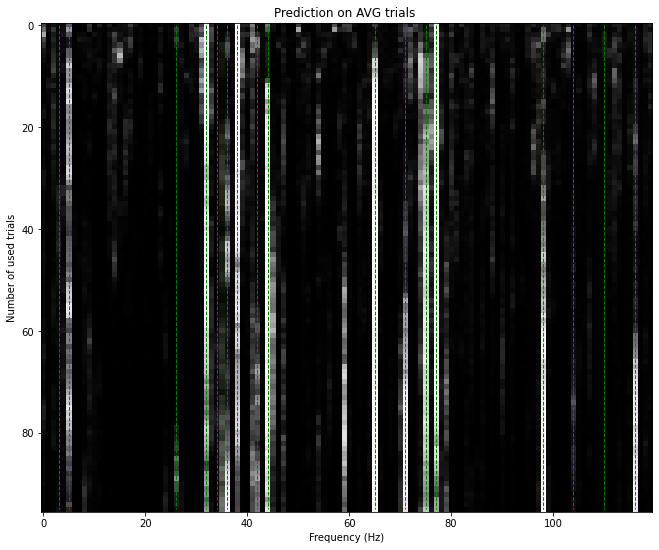

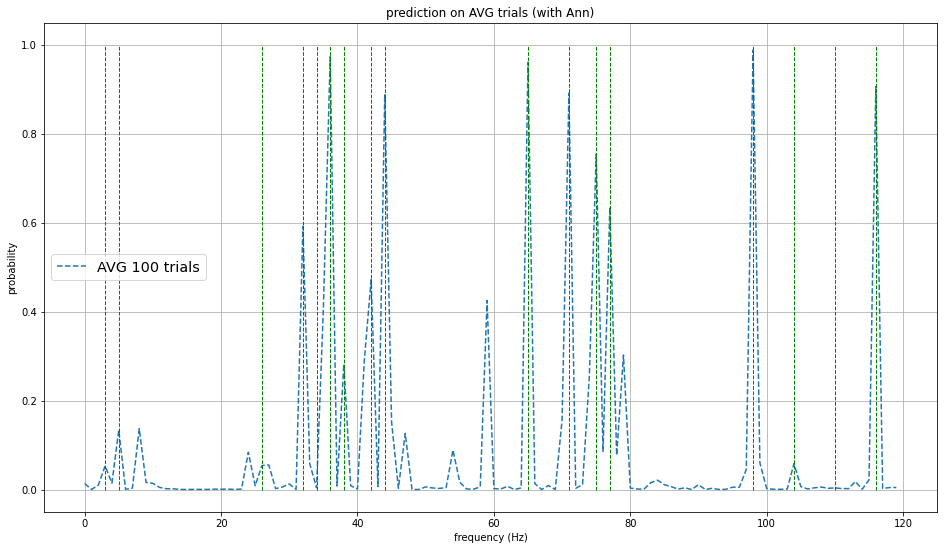

In [10]:
plt.figure(figsize=(16, 9))
plt.imshow(predictions, cmap='gray')
plot1bar(labels2plt, L=96)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Number of used trials')
plt.title('Prediction on AVG trials ')

    
# plot probility on AVG-trials: [50, 60, 70, 80, 90, 100]
# nAVG = [50, 60, 70, 80, 90, 100]
nAVG = [ 100]
plt.figure(figsize=(16, 9))
for i in range(len(nAVG)):  
    prediction_on_1AVG = predictions[nAVG[i]-5]
    plt.plot(prediction_on_1AVG, label= 'AVG {} trials'.format(nAVG[i]), linestyle='--')

   
plot1bar(labels2plt, L=2)
plt.grid(True)
plt.xlabel('frequency (Hz)')
plt.ylabel('probability')
plt.title('prediction on AVG trials (with Ann)')
plt.legend(loc='best', fontsize='x-large')
     

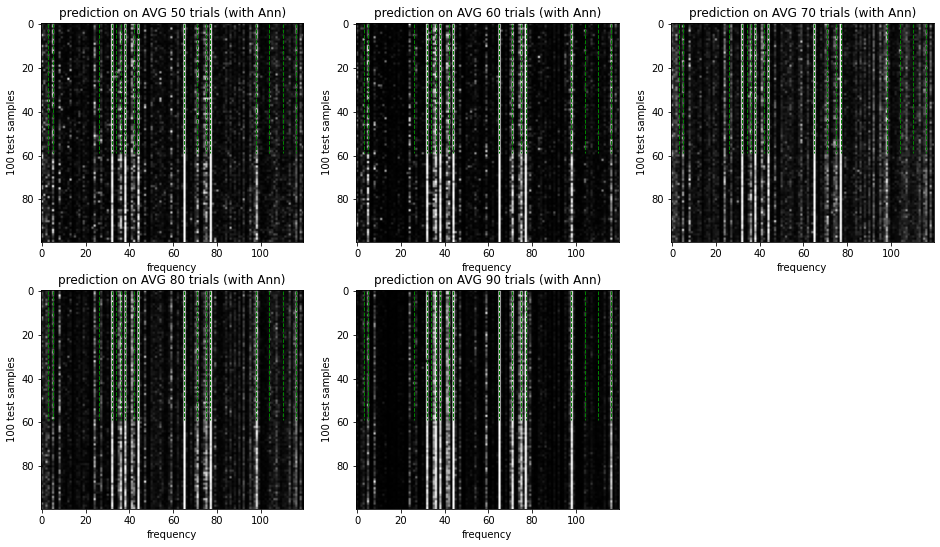

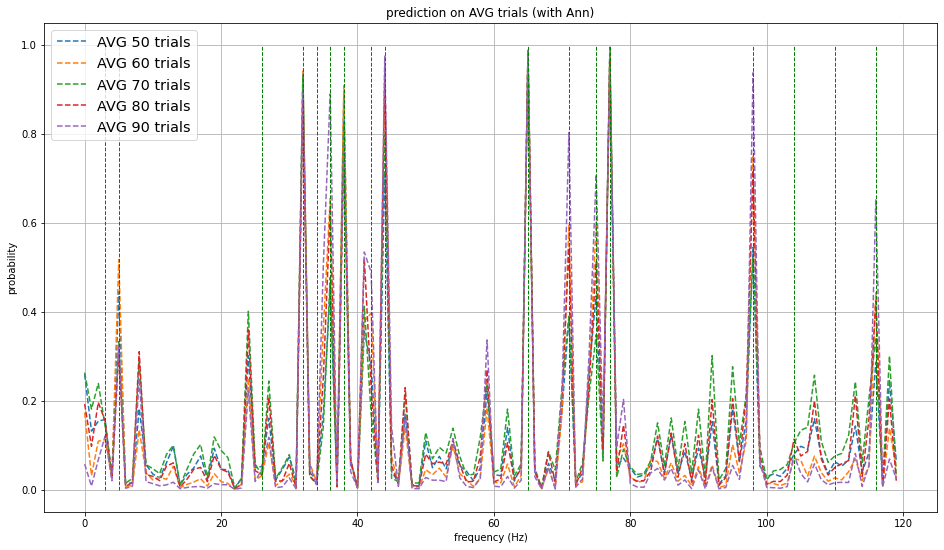

In [11]:
#%% test (2) the best_trained_model on randomly-selected EEG, ntrials = [50, 60, 70, 80, 90]
data2 =  data_test_ram

ntrials = [50, 60, 70, 80, 90]
plt.figure(figsize=(16, 9))
for i in range(5):  
    x_test2 = data2[0, i] # [50, 60, 70, 80]
    x_test2 =  normalize_matrix_1(x_test2)
    predictions = model.predict(x_test2)
    
    plt.subplot(2,3,i+1)
    plt.imshow(predictions, cmap='gray')
    plot1bar(labels2plt)
    plt.xlabel('frequency')
    plt.ylabel('100 test samples')
    plt.title('prediction on AVG {} trials (with Ann)'.format(ntrials[i]))

    
# plot probility on AVG trials = [50, 60, 70, 80, 90]
plt.figure(figsize=(16, 9))
for i in range(5):  
    x_test2 = data2[0, i] # [50, 60, 70, 80]
    x_test2 =  normalize_matrix_1(x_test2)
    predictions = model.predict(x_test2)
    predictions_mean = np.mean(predictions, axis = 0)
    plt.plot(predictions_mean, label= 'AVG {} trials'.format(ntrials[i]), linestyle='--')
    
plot1bar(labels2plt, L=2)
plt.grid(True)
plt.xlabel('frequency (Hz)')
plt.ylabel('probability')
plt.title('prediction on AVG trials (with Ann)')
plt.legend(loc='best', fontsize='x-large')
    

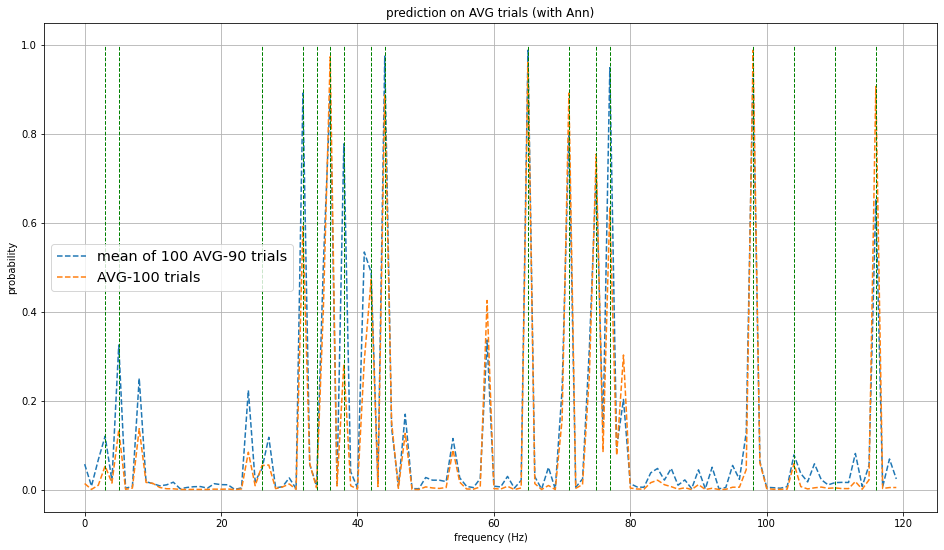

In [12]:
# plot probility on AVG trials = [50, 60, 70, 80, 90]
plt.figure(figsize=(16, 9))
x_test2 = data2[0, 4]  
x_test2 =  normalize_matrix_1(x_test2)
predictions = model.predict(x_test2)
predictions_mean = np.mean(predictions, axis = 0)
plt.plot(predictions_mean, label= 'mean of 100 AVG-90 trials', linestyle='--')
plt.plot(prediction_on_1AVG, label= 'AVG-100 trials', linestyle='--')        
plot1bar(labels2plt, L=2)
plt.grid(True)
plt.xlabel('frequency (Hz)')
plt.ylabel('probability')
plt.title('prediction on AVG trials (with Ann)')
plt.legend(loc='best', fontsize='x-large')